In [1]:
import gym
import numpy as np
from offsim4rl.envs import gridworld
from offsim4rl.agents import spinup
import torch

No protocol specified


In [2]:
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling
from offsim4rl.evaluators.queue_evaluator import QueueEvaluator

In [3]:
class OracleEncoder(object):
    def __init__(self):
        pass
    def encode(self, observations):
        zs = []
        for x, y in observations:
            xx, yy = int(x*5), int(y*5)
            z = xx + 5*yy
            zs.append(z)
        return zs

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
from offsim4rl.data import SAS_Dataset
from offsim4rl.encoders.homer import HOMEREncoder
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.88it/s]


In [5]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-17 21:45:04,052 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [6]:
qbe = QueueEvaluator(
    dataset,
    num_states=25,
    encoder=OracleEncoder(),
)

## Visualize trajectories

In [7]:
psrs.reset_sampler(seed=0)

NameError: name 'psrs' is not defined

In [ ]:
from offsim4rl.agents import tabular
from offsim4rl.envs import gridworld

In [ ]:
env_ = gridworld.MyGridNavi(num_steps=1000)
env_.reset_task(np.array([4,4]))

In [ ]:
Q_star, _ = tabular.qlearn(env_, 100, tabular.epsilon_greedy_policy, gamma=1, alpha=1, epsilon=1, seed=0, save_Q=False)

In [ ]:
pi_ = tabular.epsilon_greedy_policy(Q_star, dict(epsilon=0.2))

In [ ]:
def policy_(coords):
    x, y = coords
    col, row = int(np.floor(x*5)), int(np.floor(y*5))
    idx = col + row * 5
    return pi_[idx]

In [ ]:
gamma = 1.0
episodes_psrs = []
for i in range(50):
    G = 0
    t = 0
    S = psrs.reset(seed=i)
    rng = np.random.default_rng(seed=i)
    done = False
    episode = []
    while not done: # S is not a terminal state
        p = torch.distributions.Categorical(probs=torch.tensor(policy_(tuple(S))))
        A, S_, R, done, info = psrs.step_dist(p)
        episode.append((S, A, R, S_, done, p, {**info, 't': t}))

        S = S_
        G = G + (gamma ** t) * R
        t = t + 1
    episodes_psrs.append(episode)

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
for episode in episodes_psrs:
    plt.plot([xy[0] for xy, *_ in episode] + [episode[-1][3][0]], [xy[1] for xy, *_ in episode] + [episode[-1][3][1]], marker='.', lw=1, ms=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()

In [ ]:
env = gym.make('MyGridNaviCoords-v1')
env.reset_task(np.array([4,4]))

In [ ]:
gamma = 1.0
episodes = []
for i in range(50):
    ep_psrs = episodes_psrs[i]
    G = 0
    t = 0
    S = env.reset(seed=i)
    rng = np.random.default_rng(seed=i)
    done = False
    episode = []
    while not done:
        if t == len(ep_psrs):
            break
        A = ep_psrs[t][1]
        S_, R, done, info = env.step(A)
        episode.append((S, A, R, S_, done, p, {**info, 't': t}))

        S = S_
        G = G + (gamma ** t) * R
        t = t + 1
    episodes.append(episode)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
for episode in episodes:
    plt.plot([xy[0] for xy, *_ in episode] + [episode[-1][3][0]], [xy[1] for xy, *_ in episode] + [episode[-1][3][1]], marker='.', lw=1, ms=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
for ep1, ep2 in zip(episodes[12:13], episodes_psrs[12:13]):
    plt.plot([xy[0] for xy, *_ in ep1] + [ep1[-1][3][0]], [xy[1] for xy, *_ in ep1] + [ep1[-1][3][1]], marker='.', lw=1, ms=3, c='b', label='true')
    plt.plot([xy[0] for xy, *_ in ep2] + [ep2[-1][3][0]], [xy[1] for xy, *_ in ep2] + [ep2[-1][3][1]], marker='.', lw=1, ms=3, c='r', label='psrs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
for ep1, ep2 in zip(episodes[10:11], episodes_psrs[10:11]):
    plt.plot([xy[0] for xy, *_ in ep1] + [ep1[-1][3][0]], [xy[1] for xy, *_ in ep1] + [ep1[-1][3][1]], marker='.', lw=1, ms=3, c='b', label='true')
    plt.plot([xy[0] for xy, *_ in ep2] + [ep2[-1][3][0]], [xy[1] for xy, *_ in ep2] + [ep2[-1][3][1]], marker='.', lw=1, ms=3, c='r', label='psrs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

## Learn

In [7]:
# true env for online validation
env = gym.make('MyGridNaviCoords-v1', seed=100000)
env.reset_task(np.array([4, 4]))

array([4, 4])

In [8]:
qbe.reset_sampler(seed=0)
seed = 0
spinup.ppo(
    env_fn=lambda: qbe, steps_per_epoch=5000, epochs=50, seed=seed, 
    logger_kwargs=dict(output_dir=f'./outputs/grid_qbe_oracle/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo_test_qbe_oracle'), 
    ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
    validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/grid_qbe_oracle/seed=0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7f145c2610e0>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo_test_qbe_oracle",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<offsim4rl.agents.spinup.utils.logx.EpochLogger object at 0x7f14ab4a1a90>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo_test_qbe_oracle",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/grid_qbe_oracle/seed=0",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/grid_qbe_oracle/seed=0/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
          

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv(f'./outputs/grid_qbe_oracle/seed={seed}/progress.txt', sep='\t')

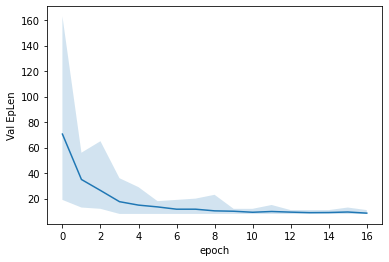

In [11]:
plt.plot(df['AverageVal_EpLen'])
plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

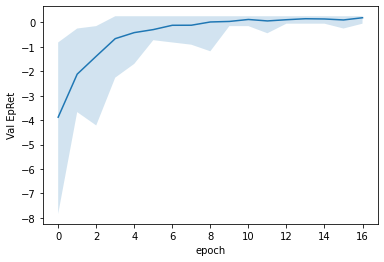

In [12]:
plt.plot(df['AverageVal_EpRet'])
plt.fill_between(df['Epoch'], df['MinVal_EpRet'], df['MaxVal_EpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()